<a href="https://colab.research.google.com/github/ayezabashir/Vision-Transformer-Architecture/blob/main/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Architecture**

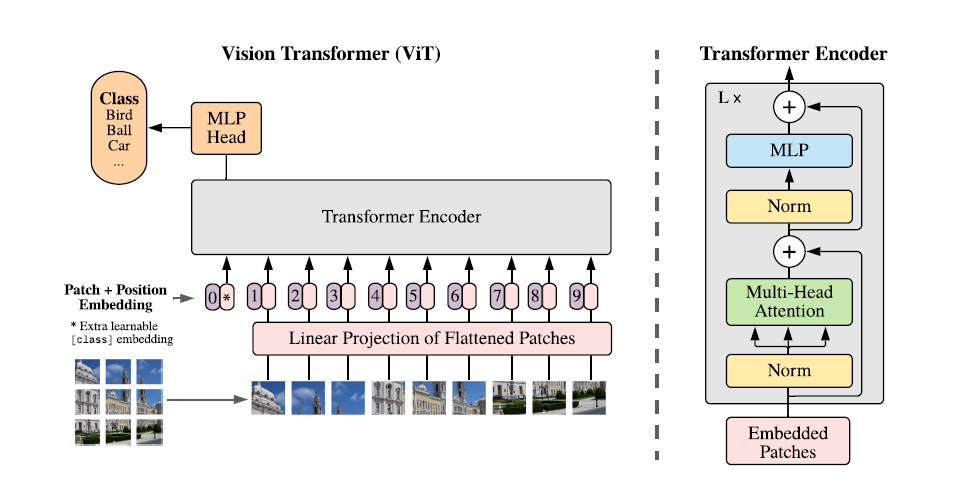

# **Four Equations**

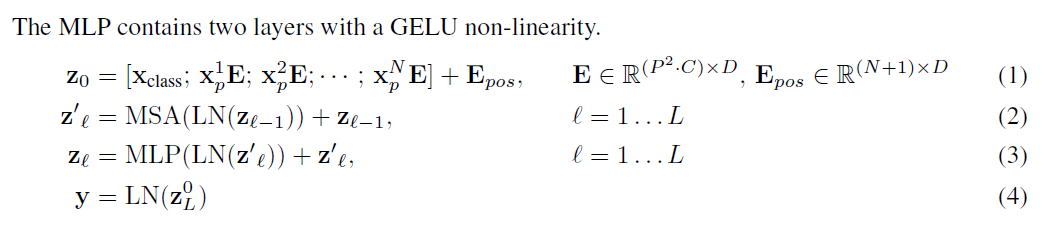

# **Components of Vision Transformer**

### 1-Images to Patches
### 2-Embeddings of Patches
### 3-[class] token
### 4-Positional Encoding
### 5-Self Attention
### 6-Multi Head attention
### 7-Multi Layer Perceptron
### 8-Layer Normalization
### 9-Transformer Encoder
### 10-Classification Head
### 11-Vision Transformer

# **Import Important Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

Training resolution is 224 (according to the research paper) so we will resize our image.

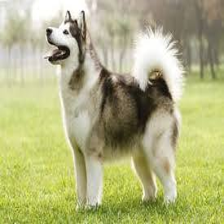

In [5]:
image=Image.open('dog.jpg').resize((224,224))
image

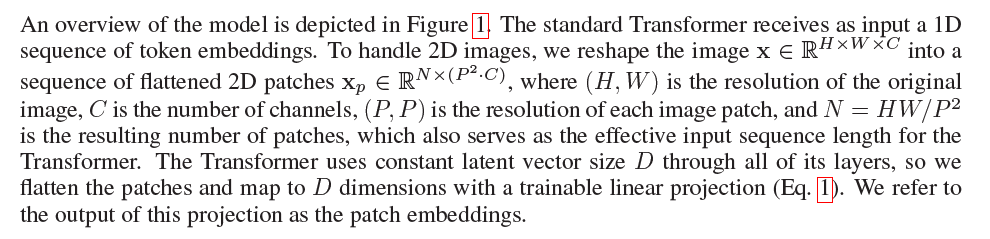

image.png

array([[[243, 244, 238],
        [242, 243, 237],
        [240, 241, 235],
        ...,
        [127, 114,  95],
        [126, 113,  94],
        [126, 113,  94]],

       [[228, 229, 223],
        [228, 229, 223],
        [226, 227, 221],
        ...,
        [127, 114,  95],
        [125, 112,  93],
        [125, 112,  93]],

       [[220, 221, 215],
        [220, 221, 215],
        [219, 220, 214],
        ...,
        [125, 112,  93],
        [124, 111,  92],
        [124, 111,  92]],

       ...,

       [[163, 183,  68],
        [172, 191,  77],
        [181, 199,  88],
        ...,
        [171, 182,  63],
        [180, 192,  63],
        [181, 194,  63]],

       [[163, 183,  68],
        [179, 198,  84],
        [174, 192,  81],
        ...,
        [179, 190,  69],
        [183, 197,  63],
        [189, 203,  67]],

       [[155, 175,  60],
        [177, 196,  82],
        [175, 193,  82],
        ...,
        [195, 206,  84],
        [191, 204,  69],
        [194, 208,  71]]], dtype=uint8)
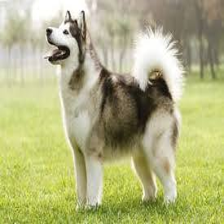

In [6]:
x=np.array(image)
x

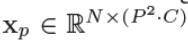